In [83]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import pylab as pl
import urllib
import os
import sys
import requests
import json
import io
from shapely.geometry import Point

%matplotlib inline

In [4]:
#urllib.request.urlretrieve('https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data', "file.zip")

('file.zip', <http.client.HTTPMessage at 0x7f2a0670ea58>)

In [7]:
os.getenv("PUIDATA")

'/home/cusp/pa1303/PUIdata'

In [215]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA")+"/geo_export_5b5d945a-f215-41d4-977b-7fa511450058.shp")

In [216]:
pumashp.crs

{'init': 'epsg:4326'}

In [4]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


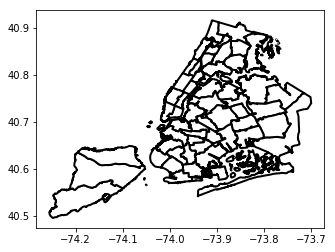

In [5]:
pumashp.plot(color="white", edgecolor="black", lw=2);

In [6]:
import myAPI

'\n'

In [7]:
myAPI = myAPI.get_key()

In [8]:
myAPI = myAPI[:-1]

In [9]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [10]:
affkeys = np.array(list(aff1y['variables'].keys()))


In [11]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007MA',
  'Annotation of M

In [12]:
keyNhouseholds = 'B28002_001E'

In [13]:
keyNBB = 'B28002_004E'

In [199]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [200]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [16]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [201]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']
pumaBB['pcBB'] = pumaBB.B28002_004E / pumaBB.B28002_001E * 100

In [202]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50.csv",
                   usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

In [62]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,36,81.7,0.2
1,3600100,80.6,2.6
2,3600200,75.7,2.2
3,3600300,79.8,2.6
4,3600401,81.4,2.4


(146, 9)

In [203]:
bbpc = bbpc.drop(bbpc.index[0])

In [204]:
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000

In [217]:
pumashp.puma = pumashp.puma.astype(int)

In [206]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["state", "gid", "pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,state,gid,pcBB,HC01,diff
count,145.0,145.000000,145.000000,145.000000,145.000000
mean,36.0,2826.827586,81.845478,81.843448,0.026217
std,0.0,1210.054822,7.063369,7.065358,0.014480
min,36.0,100.000000,54.932945,54.900000,0.000178
25%,36.0,1900.000000,77.770257,77.800000,0.012252
50%,36.0,3208.000000,82.826141,82.800000,0.027230
75%,36.0,3809.000000,87.305077,87.300000,0.039090
max,36.0,4114.000000,93.404143,93.400000,0.049872


In [218]:
pumashp = pumashp.merge(diff_, left_on='puma', right_on='gid')

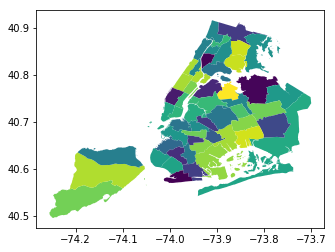

In [80]:
pumashp.plot(column='diff', cmap='viridis')

In [81]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv")

In [82]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [86]:
geometry = [Point(xy) for xy in zip(linkNYC.longitude, linkNYC.latitude)]

In [87]:
linkNYC = linkNYC.drop(['longitude','latitude'], axis= 1)

In [88]:
linkNYC = GeoDataFrame(linkNYC, geometry=geometry)

In [155]:
linkNYC.crs = {'init': 'epsg:4326'}

In [89]:
linkNYC.head()

,Unnamed: 0,link_site,date_link_,geometry
0,0,bk-01-138951,2017-07-01,POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,2017-07-01,POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,2017-07-01,POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,2017-04-28,POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,2017-03-31,POINT (-73.953439 40.728133)


In [91]:
linkNYC.date_link_ = pd.to_datetime(linkNYC.date_link_)

In [127]:
linkNYC['age'] = pd.datetime.now().date() - linkNYC.date_link_

In [121]:
linkNYC.age.dtype

dtype('int64')

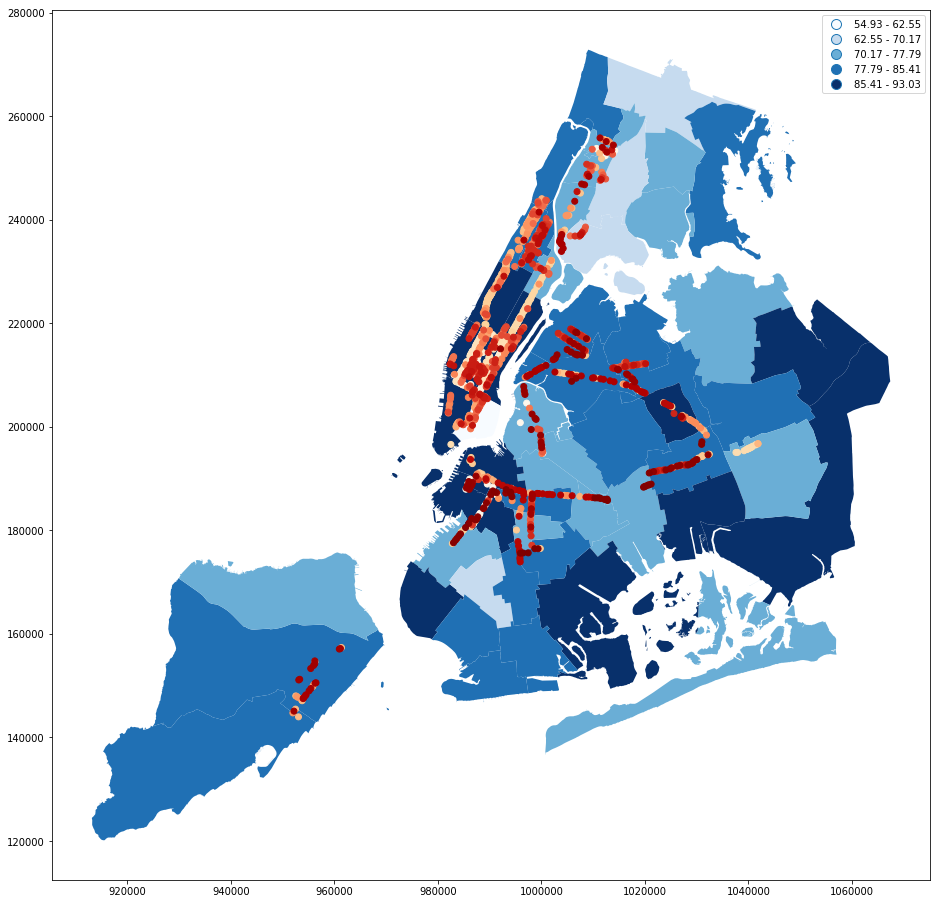

In [208]:
base = pumashp.plot(column='pcBB', cmap='Blues', scheme='equal_interval', k=5, figsize=(16, 16), legend=True)
linkNYC.plot(cmap='OrRd', ax=base)

## This map shows the locations of linknycs across NYC and the bins represent the percent of the population with broadband access.

In [214]:
keyPop = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [219]:
pumashp = pumashp.merge(pumaPop, left_on='puma', right_on='public use microdata area')

In [220]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,state_x,gid,pcBB,HC01,diff,B00001_001E,NAME,state_y,public use microdata area,Unnamed: 4
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,36,3701,84.275820,84.3,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,36,3702,68.310015,68.3,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36,3703,82.826141,82.8,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",36,3704,72.553737,72.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,36,3705,69.425612,69.4,0.025612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN


In [210]:
#pumashp = pumashp.drop(['public use microdata area', 'HC01','gid'], axis=1)

In [221]:
pumashp = pumashp.to_crs(epsg='2263')

In [157]:
linkNYC = linkNYC.to_crs(epsg='2263')

In [222]:
linkpp = gpd.sjoin(linkNYC, pumashp, how='inner').groupby('puma')[['link_site']].count()


In [223]:
linkpp=linkpp.reset_index()

In [245]:
linkpp.shape

(37, 2)

In [224]:
pumashp = pumashp.merge(linkpp, how='left', left_on='puma', right_on='puma')

In [246]:
pumashp['link_per_100'] = ( 100 * pumashp.link_site) / pumashp.B00001_001E 

In [247]:
pumashp.link_per_100.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: link_per_100, dtype: float64

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


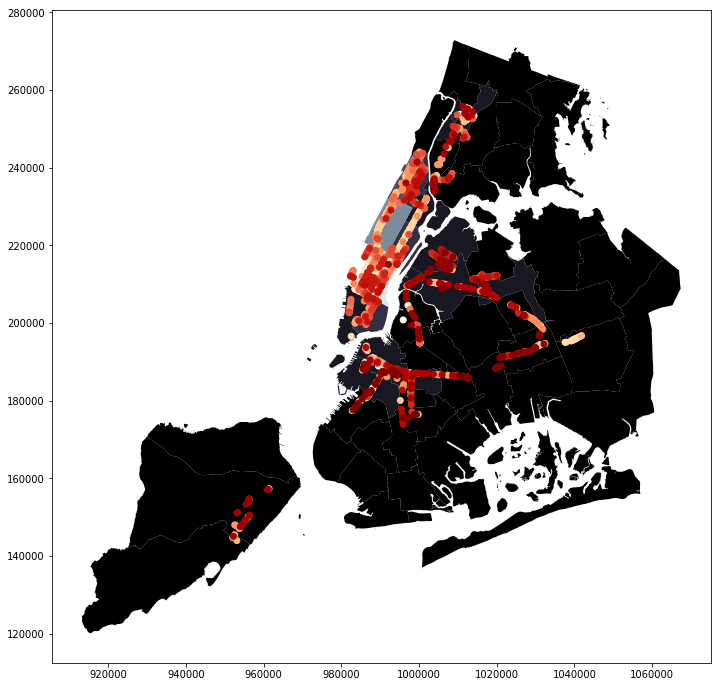

In [248]:
base = pumashp.plot(column='link_per_100', cmap='bone',
                                      scheme='equal_interval', k=10, figsize=(12,12))

linkNYC.plot(ax=base, cmap='OrRd')

## This map shows the number of link stations per 100 people. From the map it looks like many areas do receive access to these stations